In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from preparation.data import Data
import h5py
import os
import shutil

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
def leakyReLU(x, alpha):
    return tf.maximum(alpha*x, x)

In [3]:
# Simple function to plot number images.
def plot_images(plt_num, images, dim):
    # Standard parameters for the plot.
    
    mpl.rcParams["figure.figsize"] = dim, dim
    fig = plt.figure()
    for i in range(0, plt_num):
        fig.add_subplot(1, 10, i+1)
        img = images[i, :, :, :]
        plt.imshow(img)
    plt.show()

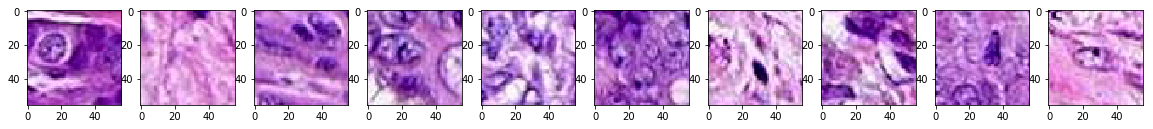

In [4]:
data = Data(dataset='nki', marker='he', patch_h=56, patch_w=56, n_channels=3, batch_size=10)
images, label = data.training.next_batch(10)

plot_images(plt_num=10, images=images, dim=20)

In [5]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    real_images = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_images')
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return real_images, z_input, learning_rate

In [6]:
def discriminator(images, reuse, alpha, use_bn=True):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Padding = 'Same' -> H_new = H_old // Stride
        
        # First layer: 
        # Input Shape: (56, 56, 1)
        # Output Shape: (28, 2816, 64)
        net = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), name='c1')
        net = leakyReLU(net, alpha)
        
        # Second layer: 
        # Input Shape: (28, 28, 64)
        # Output Shape: (14, 14, 128)
        net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), name='c2')
        if use_bn:
            net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)
        
        # Third layer: 
        # Input Shape: (14, 14, 128)
        # Output Shape: (8, 8, 256)
        net = tf.layers.conv2d(inputs=net, filters=256, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), name='c3')
        if use_bn:
            net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)

        # Flattening.
        net = tf.layers.flatten(net, name='flatten')

        # Dense Layer.
        net = tf.layers.dense(net, 1024, activation=None)
        if use_bn:
            net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)
        
        # Dense Layer.
        logits = tf.layers.dense(net, 1, activation=None)
        output = tf.nn.sigmoid(logits)
        
        return output, logits

In [7]:
def generator(z_input, out_channel_dim, reuse, is_train, alpha):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # Dense Layer.
        net = tf.layers.dense(inputs=z_input, units=1024, activation=None)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Doesn't work ReLU
        # leaky_bfc1 = tf.nn.relu(bn_fully1)
        
        # Dense Layer.
        net = tf.layers.dense(inputs=net, units=256*7*7, activation=None)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Doesn't work ReLU
        # leaky_bfc2 = tf.nn.relu(bn_fully2)
        
        net = tf.reshape(net, (-1, 7, 7, 256))
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=256, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), name='c1')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Doesn't work ReLU
        # leaky_c1 = tf.nn.relu(bc1)
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), name='c2')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Doesn't work ReLU
        # leaky_c2 = tf.nn.relu(bc2)
        
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), name='c3')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Doesn't work ReLU
        # leaky_c3 = tf.nn.relu(bc3)
        
        # Conv
        logits = tf.layers.conv2d_transpose(inputs=net, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                            name='logits')
        output = tf.nn.sigmoid(logits, name='output')
        
        return output

In [8]:
def show_generated(session, output_fake, n_images, z_input):
    z_dim = z_input.get_shape()[-1]
    sample_z = np.random.uniform(low=-1., high=1., size=(n_images, z_dim))
    feed_dict = {z_input:sample_z}
    gen_samples = session.run(output_fake, feed_dict=feed_dict)
    plot_images(plt_num=n_images, images=gen_samples, dim=20)    
    return gen_samples, sample_z

In [9]:
def save_loss(losses, data_out_path, dim):    
    mpl.rcParams["figure.figsize"] = dim, dim
    plt.rcParams.update({'font.size': 22})
    losses = np.array(losses)
    fig, ax = plt.subplots()
    plt.plot(losses[:, 0], label='Discriminator', alpha=0.5)
    plt.plot(losses[:, 1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.savefig('%s/training_loss.png' % data_out_path)

In [10]:
def setup_output(show_epochs, epochs, data, n_images, image_height, image_width, image_channels, z_dim, data_out_path):
    checkpoints_path = os.path.join(data_out_path, 'checkpoints')
    checkpoints = os.path.join(checkpoints_path, 'DCGAN.ckt')
    gen_images_path = os.path.join(data_out_path, 'images')
    gen_images = os.path.join(gen_images_path, 'gen_images.h5')
    latent_images = os.path.join(gen_images_path, 'latent_images.h5')
    if os.path.isdir(checkpoints_path):
         shutil.rmtree(checkpoints_path)
    if os.path.isdir(gen_images_path):
         shutil.rmtree(gen_images_path)
    os.makedirs(checkpoints_path)
    os.makedirs(gen_images_path)

    size_img = (epochs*data.training.iterations)//show_epochs
    img_db_shape = (size_img, n_images, image_height, image_width, image_channels)
    latent_db_shape = (size_img, n_images, z_dim)
    hdf5_gen = h5py.File(gen_images, mode='w')
    hdf5_latent = h5py.File(latent_images, mode='w')
    img_storage = hdf5_gen.create_dataset(name='generated_img', shape=img_db_shape, dtype=np.float32)
    latent_storage = hdf5_latent.create_dataset(name='generated_img', shape=latent_db_shape, dtype=np.float32)
    return img_storage, latent_storage, checkpoints

In [11]:
'''
Defining new cost function according to WGAN.
Loss(Lpr, Lpg) = Max-w ( Ex~pr[fw(x)] - Ez~pg(z)[fw(Gtheta(z))] )  

Generator would want to find the theta parameters that minimizes the cost of moving the distributions.
Discriminator/Critic wants to find the w parameters that approximate better the Wassertein distance. Find maximum 
of the moving the distribution Pg to Pr.

'''
def loss(real_images, z_input, out_channel_dim, alpha):
    # Generator.
    fake_images = generator(z_input, out_channel_dim=out_channel_dim, reuse=False, is_train=True, alpha=alpha)
    
    # Discriminator.
    output_fake, logits_fake = discriminator(images=fake_images, reuse=False, alpha=alpha) 
    output_real, logits_real = discriminator(images=real_images, reuse=True, alpha=alpha)
    
    # Discriminator loss.
    loss_dis_real = tf.reduce_mean(logits_real)
    loss_dis_fake = tf.reduce_mean(logits_fake)
    loss_dis = -(loss_dis_real - loss_dis_fake)

    # Generator loss.
    # This is where we implement -log[D(G(z))] instead log[1-D(G(z))].
    # Recall the implementation of cross-entropy, sign already in. 
    loss_gen = -loss_dis_fake
    
    return loss_dis, loss_gen

In [12]:
def optimization(loss_dis, loss_gen, learning_rate, c):
    trainable_variables = tf.trainable_variables()
    generator_variables = [variable for variable in trainable_variables if 'generator' in variable.name]
    discriminator_variables = [variable for variable in trainable_variables if 'discriminator' in variable.name]
    
    # Handling Batch Normalization.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        
        RMS_optimizer_dis = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
        train_discriminator = RMS_optimizer_dis.minimize(loss_dis , var_list=discriminator_variables)
        
        # Weight Clipping on Discriminator, this is done to ensure the Lipschitz constrain.
        dis_weight_clipping = [value.assign(tf.clip_by_value(value, -c, c)) for value in discriminator_variables]
        
        train_discriminator = tf.group(*[train_discriminator, dis_weight_clipping])
        
        # Generator.
        RMS_optimizer_gen = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
        train_generator = RMS_optimizer_gen.minimize(loss_gen, var_list=generator_variables)
        
    return train_generator, train_discriminator

In [13]:
def train(epochs, batch_size, z_dim, learning_rate, data, alpha, image_width, image_height, image_channels, data_out_path, n_critic, c):
    
    real_images, z_input, learning_rate_input = model_inputs(image_width=image_width, image_height=image_height, image_channels=image_channels, z_dim=z_dim)
    loss_dis, loss_gen = loss(real_images=real_images, z_input=z_input, out_channel_dim=image_channels, alpha=alpha)
    train_generator, train_discriminator = optimization(loss_dis=loss_dis, loss_gen=loss_gen, learning_rate=learning_rate_input, c=c)
    
    output_gen = generator(z_input=z_input, out_channel_dim=image_channels, reuse=True, is_train=False, alpha=alpha)

    global losses 
    global samples 
    
    run_epochs = 0    
    show_epochs = 100
    print_epochs = 10
    n_images = 10
        
    losses = list()
    samples = list()

    #Saver for model weights/bias, and generated images.
    saver = tf.train.Saver()
    
    img_storage, latent_storage, checkpoints = setup_output(show_epochs, epochs, data, n_images, image_height, image_width, image_channels, z_dim, data_out_path)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(1, epochs+1):
            for batch_images, batch_labels in data.training:
            
                z_batch = np.random.uniform(low=-1., high=1., size=(batch_size, z_dim))
                feed_dict = {z_input:z_batch, real_images:batch_images, learning_rate_input: learning_rate}

                # Update critic and clip gradients.
                session.run(train_discriminator, feed_dict=feed_dict)
               
                if run_epochs % n_critic:
                    session.run(train_generator, feed_dict=feed_dict)
               
                if run_epochs%print_epochs==0:
                    feed_dict = {z_input:z_batch, real_images:batch_images}
                    epoch_loss_dis = session.run(loss_dis, feed_dict=feed_dict)
                    epoch_loss_gen = session.run(loss_gen, feed_dict=feed_dict)
                    losses.append((epoch_loss_dis, epoch_loss_gen))
                    print('Epochs %s/%s: Generator Loss: %s. Discriminator Loss: %s' % (epoch, epochs, np.round(epoch_loss_gen, 3), np.round(epoch_loss_dis, 3)))
                if run_epochs%show_epochs == 0:
                    gen_samples, sample_z = show_generated(session=session, output_fake=output_gen, n_images=n_images, z_input=z_input)
                    img_storage[run_epochs//show_epochs] = gen_samples
                    latent_storage[run_epochs//show_epochs] = sample_z
                    saver.save(sess = session, save_path=checkpoints, global_step=run_epochs)
                
                run_epochs+=1
            data.training.reset()

In [ ]:
# Image details.
image_width = 56
image_height = 56
image_channels = 3

# Hyperparameters.
epochs = 3
batch_size = 64
z_dim = 100
learning_rate = 5e-5
alpha = 0.2

# WGAN Hyperparameters.
c =0.01
n_critic = 5

global losses 
global samples

name_run = 'h%s_w%s_n%s' % (image_height, image_width, image_channels)
data_out_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/Cancer_TMA_Generative/data model output/WGAN/%s' % name_run
data = Data(dataset='nki', marker='he', patch_h=image_height, patch_w=image_width, n_channels=image_channels, batch_size=batch_size)

with tf.Graph().as_default():
   train(epochs, batch_size, z_dim, learning_rate, data, alpha, image_width, image_height, image_channels, data_out_path, n_critic, c)

save_loss(losses, data_out_path, dim=20)